<a href="https://colab.research.google.com/github/fataltes/quickNBs/blob/master/lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.linear_model import LinearRegression
import scipy.stats as sst

In [85]:
import torch
from torch.autograd import Variable
import math

Example initialization

In [18]:
n = 100
X = np.array(np.random.uniform(-10,10, n), dtype=np.float32)
X = X.reshape(-1,1)
true_w, true_b, true_s = -1, 2, 0.1
noise = np.random.normal(0, true_s, n) 

y = np.array(true_w * X[:,0] + true_b + noise, dtype=np.float32)  
y = y.reshape(-1, 1)

In [180]:
learning_rate = 0.0002
max_epoch = 1000
init_w, init_b, init_s = -1,1,0.5

# Manual gradient descent

In [184]:
eps = 10**-20
def gradient_descent(X, y, w, b, s, learning_rate):
    # s = s + eps
    dw = (1.0/(s**2)) * np.sum((b + (w - 1) * X[:,0])*X[:,0]) # ∂e/∂w
    db = (1.0/(s**2)) * np.sum(b - (1-w)*X[:,0])       # ∂e/∂b
    theta = ((1-w) * X[:,0] - b ).T @ ((1-w) * X[:,0] - b )
    ds = -1 * ((n/(s+eps)) + (theta * (s**-3)))
    w_new = w - learning_rate * dw        # minus sign since we are minizing
    b_new = b - learning_rate * db
    s_new = s - learning_rate * ds
    # print(dw, db, ds, ll(X,w_new, b_new, s_new))
    return w_new, b_new, s_new

def ll(X,w,b,s):
    return -1 * (-1 * n * np.log(s*np.square(2*np.pi)) - (1.0/(2*s**2))*(((1-w)*X[:,0]-b).T@((1-w)*X[:,0]-b)))

def get_loss(X,y,w,b,s):
    return (y[:,0] - (w * X[:,0] + b + sst.norm.pdf(X[:,0], 0, s)) ).T @ (y[:,0] - (w * X[:,0] + b + sst.norm.pdf(X[:,0], 0, s)))   # square loss, 
    

w, b, s = init_w, init_b, init_s
print(f'start with loss value: {get_loss(X,y,w,b,s):.0f} and {ll(X, w, b, s)}')
for epoch in range(1,max_epoch+1):
    w,b,s = gradient_descent(X, y, w, b, s, learning_rate)
    if epoch % 100 == 0:
      print(f'for w={w:.2f}, b={b:.2f}, s={s:.3f} -->> loss={ll(X,w,b,s):.0f}')

if b > 0:
    print(f'y = {w:.2f} x + {b:.2f} + norm(0, {s:.3f})')
else:
    print(f'y = {w:.2f} x - {-b:.2f} + norm(0, {s:.3f})')

start with loss value: 94 and 32552.539992100876
for w=4.95, b=0.95, s=26.494 -->> loss=740
for w=4.52, b=0.94, s=26.630 -->> loss=731
for w=4.14, b=0.94, s=26.752 -->> loss=724
for w=3.81, b=0.93, s=26.864 -->> loss=719
for w=3.51, b=0.93, s=26.968 -->> loss=715
for w=3.25, b=0.92, s=27.065 -->> loss=711
for w=3.02, b=0.92, s=27.157 -->> loss=709
for w=2.81, b=0.92, s=27.246 -->> loss=707
for w=2.62, b=0.91, s=27.331 -->> loss=706
for w=2.46, b=0.91, s=27.413 -->> loss=704
y = 2.46 x + 0.91 + norm(0, 27.413)


In [ ]:
plt.scatter(X, y, s=5, color="r")
plt.scatter(X, X[:, 0] * w + b + sst.norm.pdf(X[:,0], 0, s), s=5, color="b")

# Pytorch and Adam optimizer

In [170]:
xx = Variable(torch.from_numpy(X)).type(torch.FloatTensor)
ww = Variable(torch.Tensor(1), requires_grad=True).type(torch.FloatTensor)
bb = Variable(torch.Tensor(1), requires_grad=True).type(torch.FloatTensor)
ss = Variable(torch.Tensor(1), requires_grad=True).type(torch.FloatTensor)
torch.nn.init.constant_(ww, -1)
torch.nn.init.constant_(bb, 1)
torch.nn.init.constant_(ss, 0.5)


optimizer = torch.optim.Adam([ww, bb, ss], lr=learning_rate)

for t in range(max_epoch):

    optimizer.zero_grad()

    NLL = -1 * ( -n*torch.log(ss * np.sqrt(2*math.pi)) - (1.0/torch.square(2*ss))*torch.matmul((((1-ww)*xx)-bb).transpose(0,1),((1-ww)*xx)-bb))
    NLL.backward()

    optimizer.step()

    if t % 100 == 0:
      print("loglik  =", NLL.data.numpy(), " | s =", ss.data.numpy(), "dL/ds = ", ss.grad.data.numpy(), 
            " | w =", ww.data.numpy(), "dL/dw = ", ww.grad.data.numpy(),
            " | b =", bb.data.numpy(), "dL/db = ", bb.grad.data.numpy())
      
    # ww.data -= learning_rate * ww.grad.data
    # ww.grad.data.zero_()

    # bb.data -= learning_rate * bb.grad.data
    # bb.grad.data.zero_()

    # ss.data -= learning_rate * ss.grad.data
    # ss.grad.data.zero_()


loglik  = [[16149.715]]  | s = [0.5002] dL/ds =  [-64308.543]  | w = [-0.9998] dL/dw =  [-16066.173]  | b = [0.9998] dL/db =  [121.93471]
loglik  = [[14669.397]]  | s = [0.5197277] dL/ds =  [-56176.727]  | w = [-0.98010206] dL/dw =  [-14734.2295]  | b = [0.98015904] dL/db =  [110.00839]
loglik  = [[13429.456]]  | s = [0.5380721] dL/ds =  [-49636.43]  | w = [-0.9611631] dL/dw =  [-13614.58]  | b = [0.9614266] dL/db =  [100.02875]
loglik  = [[12375.318]]  | s = [0.55538595] dL/ds =  [-44279.1]  | w = [-0.94288695] dL/dw =  [-12659.435]  | b = [0.94349915] dL/db =  [91.553894]
loglik  = [[11466.451]]  | s = [0.57181925] dL/ds =  [-39815.625]  | w = [-0.92517823] dL/dw =  [-11833.103]  | b = [0.9262712] dL/db =  [84.255325]
loglik  = [[10673.522]]  | s = [0.5874909] dL/ds =  [-36043.473]  | w = [-0.90795994] dL/dw =  [-11109.734]  | b = [0.9096575] dL/db =  [77.89531]
loglik  = [[9974.737]]  | s = [0.6024975] dL/ds =  [-32816.562]  | w = [-0.89116955] dL/dw =  [-10470.09]  | b = [0.8935882

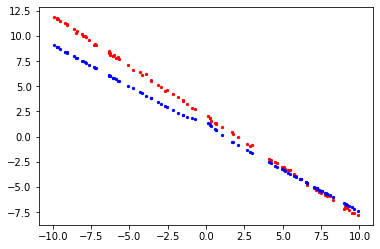

In [175]:
plt.scatter(X, y, s=5, color="r")
plt.scatter(X, (xx * ww + bb).detach().flatten() + sst.norm.pdf(X[:,0], 0, ss.detach().flatten()), s=5, color="b")

#**Only recover LR parameters** 
#### Not considering noise STD in the model

In [4]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [6]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [ ]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(X).cuda())
        labels = Variable(torch.from_numpy(y).cuda())
    else:
        inputs = Variable(torch.from_numpy(X))
        labels = Variable(torch.from_numpy(y))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

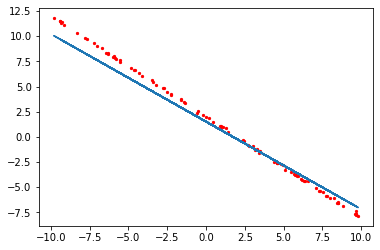

In [14]:
plt.scatter(X, y, s=5, color="r")
plt.plot(X, outputs.detach().flatten())

In [23]:
print(true_b, true_w, true_b/(1-true_w), true_s, true_s/(1-true_w))

2 -1 1.0 0.1 0.05


Adam

In [ ]:
# Adam
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        g = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * g
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(g)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        div = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr) + eps_stable)
        param[:] = param - div



mx.random.seed(1)
random.seed(1)

# Generate data.
num_inputs = 1
num_examples = 100
true_w = [-1]
true_b = 2
X2 = np.reshape(X, (num_examples, num_inputs))
ndX = nd.array(X2)
ndy = nd.array(y)
dataset = gluon.data.ArrayDataset(ndX, ndy)

# Construct data iterator.
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, ndX.take(j), ndy.take(j)

# Initialize model parameters.
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    sqrs = []
    for param in params:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())
    return params, vs, sqrs

# Linear regression.
def net(X, w, b):
    return nd.dot(X, w) + b

# Loss function.
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs, sqrs = init_params()
    total_loss = [np.mean(square_loss(net(ndX, w, b), ndy).asnumpy())]

    t = 0
    # Epoch starts from 1.
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            # Increment t before invoking adam.
            t += 1
            adam([w, b], vs, sqrs, lr, batch_size, t)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(ndX, w, b), ndy).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    return (np.reshape(w.asnumpy(), (1, -1)), b.asnumpy()[0])

In [ ]:
rt = train(batch_size=10, lr=0.1, epochs=3, period=10)

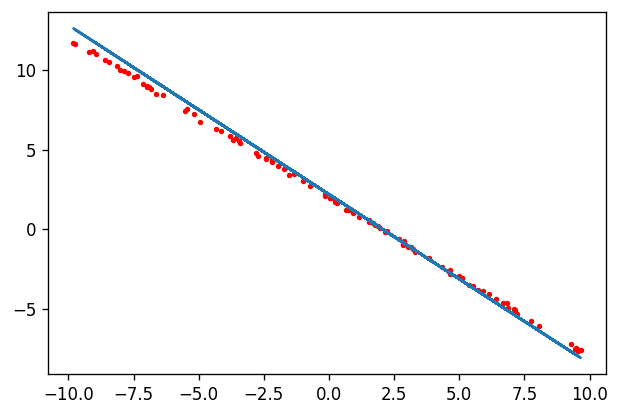

In [ ]:
plt.scatter(X, y, s=5, color="r")
plt.plot(X, rt[0][:,0]*X+rt[1])